Фиксируем seed для воспроизводимости результатов.

In [1]:
import random
import torch
import numpy as np
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

В качестве модели используйте LeNet.

In [2]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) # 28*28 -> padding=2 -> 32*32 -> kernel 5*5 -> 28*28, 6 feature maps
        self.pool = nn.MaxPool2d(2)                # 28*28 -> 14*14, 6 feature maps
        self.conv2 = nn.Conv2d(6, 16, 5)           # 14*14 -> kernel 5*5, no padding -> 10*10, 16 feature maps
        self.pool = nn.MaxPool2d(2)                # 10*10 -> 5*5, 16 feature maps
        self.fc1 = nn.Linear(16 * 5 * 5, 120)      # 120 neurons
        self.fc2 = nn.Linear(120, 84)              # 84 neurons
        self.fc3 = nn.Linear(84, 10)               # 10 outputs

    def forward(self, x):
      x = self.activation(self.pool(self.conv1(x)))
      x = self.activation(self.pool(self.conv2(x)))
      x = self.activation(self.fc1(x.flatten(start_dim=1)))
      x = self.activation(self.fc2(x))
      x = self.fc3(x)
      return x

In [3]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:

    """
        Groups contain a list of variables to output, like ["loss", "accuracy"]
        If group is None all variables will be plotted

        Title is expariment_id like "Relu_Adam_lr003"
        All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = [] #reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
           self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len,len(data[key]))
            if len(data) > 1:
               ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel('step')
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48//n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Пример работы кода для визуализации:

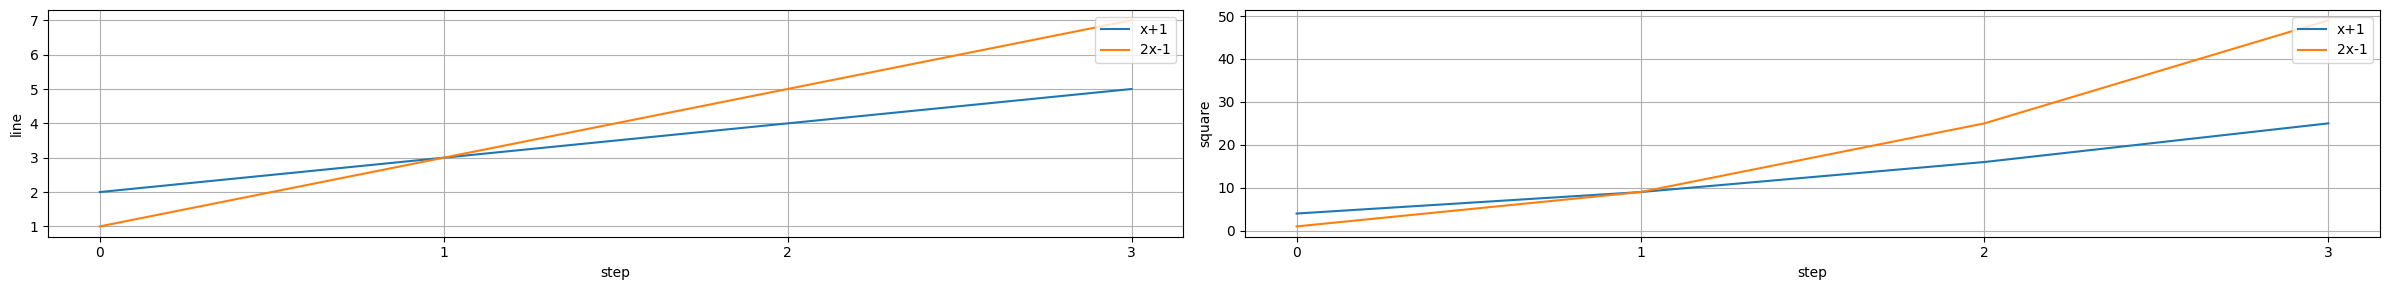

In [4]:
pp = ProgressPlotter(title='x+1')
for i in range(1, 5):
    pp.add_scalar('line', i + 1)
    pp.add_scalar('square', (i+1)**2)
pp.set_title('2x-1')
for i in range(1, 5):
    pp.add_scalar('line', 2*i - 1)
    pp.add_scalar('square', (2*i-1)**2)
pp.display(['line', 'square'])

Код для обучения модели:

In [5]:
import torch
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted.cpu() == labels.cpu()).sum().item()

@torch.inference_mode() # this annotation disable grad computation
def validate(model, test_loader, device):
    correct, total  = 0, 0
    for imgs, labels in test_loader:
        pred = model(imgs.to(device))
        total += labels.size(0)
        correct += get_correct_count(pred, labels)
    return correct / total

Ранее для обучения модели мы писали функцию `train`. Процесс обучения может быть также удобно реализовать с помощью класса, например, такого как `Trainer`. Можете далее использовать его и менять код по своему усмотрению.  

In [7]:
class Trainer:
  def __init__(self, model, plotter = None, lr = 0.03):
    self.model = model
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)  # Weight update
    self.criterion = nn.CrossEntropyLoss() # Loss function
    self.plotter = ProgressPlotter() if plotter is None else plotter
    self.loss_hist = []

  def __call__(self, train_loader, val_loader, epochs=6):
    global device
    self.model.to(device)
    self.model.train()
    for  epoch in tqdm(range(epochs)):
        self.loss_hist = []
        correct, total = 0, 0
        for imgs, labels in train_loader:
            correct += self.process_batch(imgs, labels)
            total += len(labels)
        self.plotter.add_scalar("Loss/train", np.mean(self.loss_hist))
        self.plotter.add_scalar("Accuracy/val", validate(self.model, val_loader, device=device))
        self.plotter.add_scalar("Accuracy/train", correct/total)
        self.plotter.display(["Loss/train", "Accuracy/val"])

  def process_batch(self, imgs, labels):
    self.optimizer.zero_grad()
    out = self.model(imgs.to(device))
    loss = self.criterion(out, labels.to(device))
    loss.backward()
    self.loss_hist.append(loss.item())
    self.optimizer.step()
    return get_correct_count(out.cpu(), labels)


Совет: в данном задании используйте lr = 0.03.

Download MNIST DATASET

In [8]:
from torchvision import  transforms, datasets
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.1307), (0.3081))
     ])

mnist = datasets.MNIST('MNIST', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('MNIST', train=False, download=True, transform=transform)

train_set, val_set , _ = random_split(mnist, [16000, 4000, 40000])

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(mnist_test, batch_size=256, shuffle=False, num_workers=2, drop_last=True)

# Задание 1. Сравнение оптимизаторов

В этом задании вам нужно будет обучить модель из прошлого задания тремя способами:
- оптимизатором с моментом,
- адаптивным оптимизатором,
- простым SGD (без momentum и прочих дополнительных параметров) и циклическим learning rate (нужно будет подобрать диапазон скоростей обучения).


Постройте графики Loss и accuracy. Сравните качество и скорость обучения.

## Оптимизатор с моментом

Для передачи в Trainer оптимизатора, отличного от дефолтного SGD, нужно изменить свойство `trainer.optimizer`

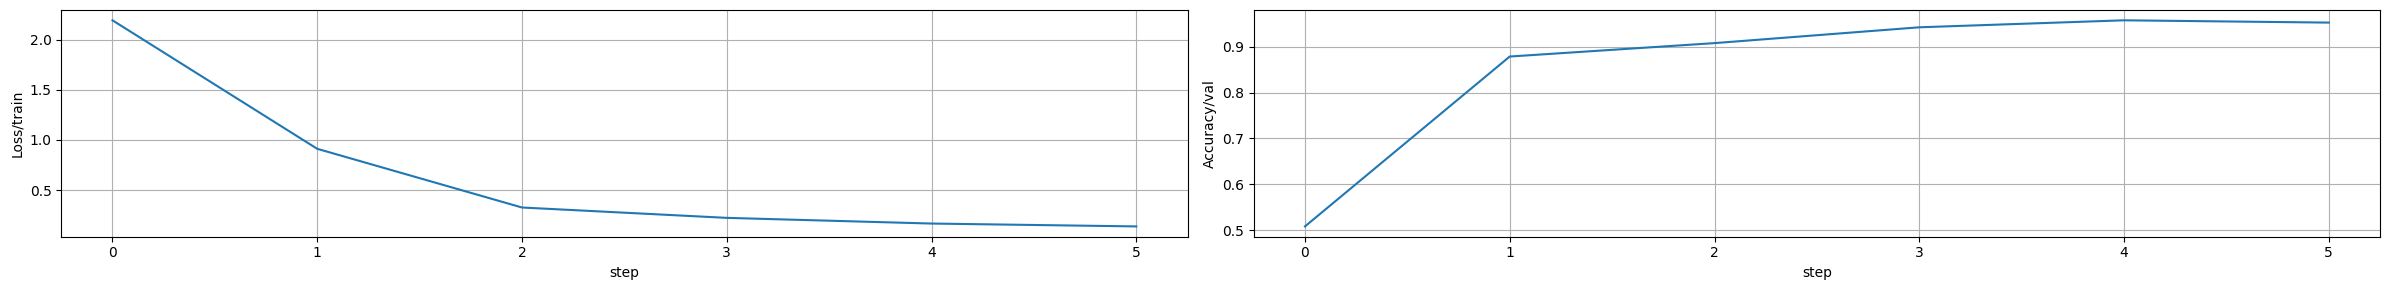

In [9]:
pp = ProgressPlotter("SGD_momentum")
model = LeNet()
trainer = Trainer(model, plotter=pp)
trainer.optimizer = torch.optim.SGD(trainer.model.parameters(), momentum=0.5, lr=0.03)
trainer(train_loader,val_loader)

Посчитайте итоговое значение accuracy на val_data с помощью функции validate.  

In [10]:
test_val = validate(trainer.model.eval(), val_loader, device)
print(f'Test accuracy: {test_val:.4f}')

Test accuracy: 0.9527


## Адаптивный оптимизатор

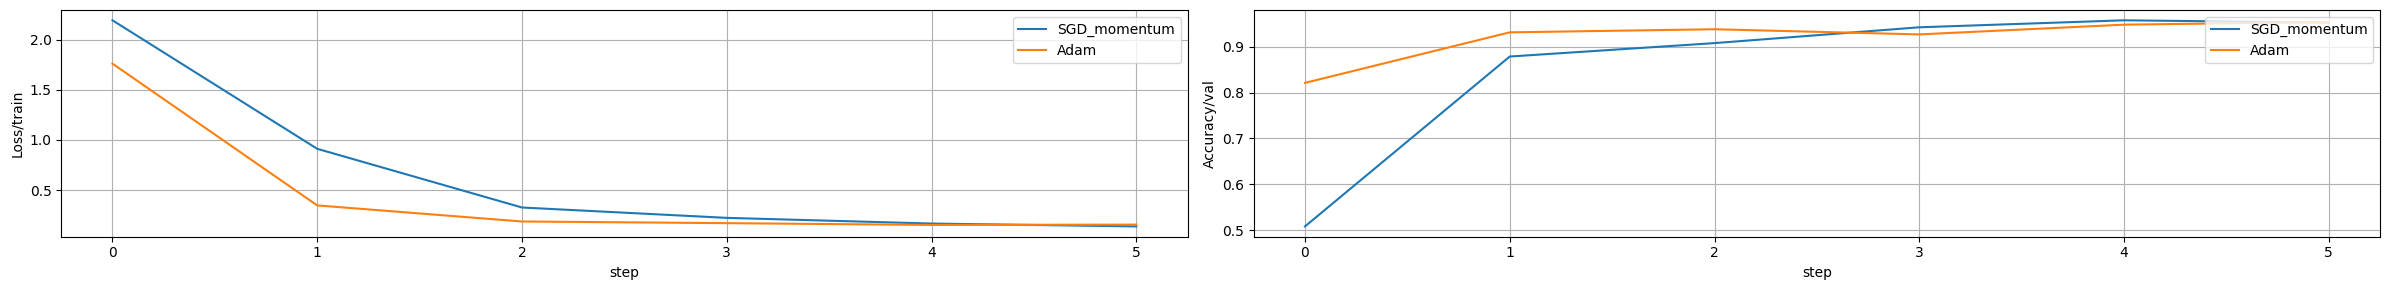

In [11]:
pp.set_title("Adam")
model = LeNet()
trainer = Trainer(model, plotter=pp)
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.03)
trainer(train_loader,val_loader)

Посчитайте итоговое значение accuracy на val_data с помощью функции validate.  

In [12]:
test_val = validate(trainer.model.eval(), val_loader, device)
print(f'Test accuracy: {test_val:.4f}')

Test accuracy: 0.9540


## Циклический learning rate
Попробуйте обучить ту же архитектуру при помощи комбинации SGD (без momentum и прочих дополнительных параметров) и циклического learning rate.

Для подбора learning rate для циклического lr используйте код из лекции или пример из kaggle. Рекомендуем подбирать значения в диапазоне $[10^{-3}, 1]$) и использовать параметры `step_size_up=40, step_size_down=40`.



In [13]:
min_lr = 0.001
max_lr = 0.5

Когда мы создавали Trainer, не подумали о том что понадобится использоваль LR_Scheduler, придется его добавить. Для этого наследуемся от класса Trainer.

In [14]:
class LRSchedulerTrainer(Trainer):
  def __init__(self, model, plotter, base_lr, max_lr):
    super().__init__(model, plotter,  lr=base_lr)
    # because we want speed up demo, step_size values decreased
    self.scheduler =  torch.optim.lr_scheduler.CyclicLR(
        self.optimizer, base_lr, max_lr,  mode="triangular", step_size_up=40,
        step_size_down=40
    )


  def process_batch(self, imgs, labels):
    total = super().process_batch(imgs, labels)
    self.scheduler.step()
    pp.add_scalar("LR", self.scheduler.get_last_lr())
    return total

Обучите модель с циклическим Learning rate

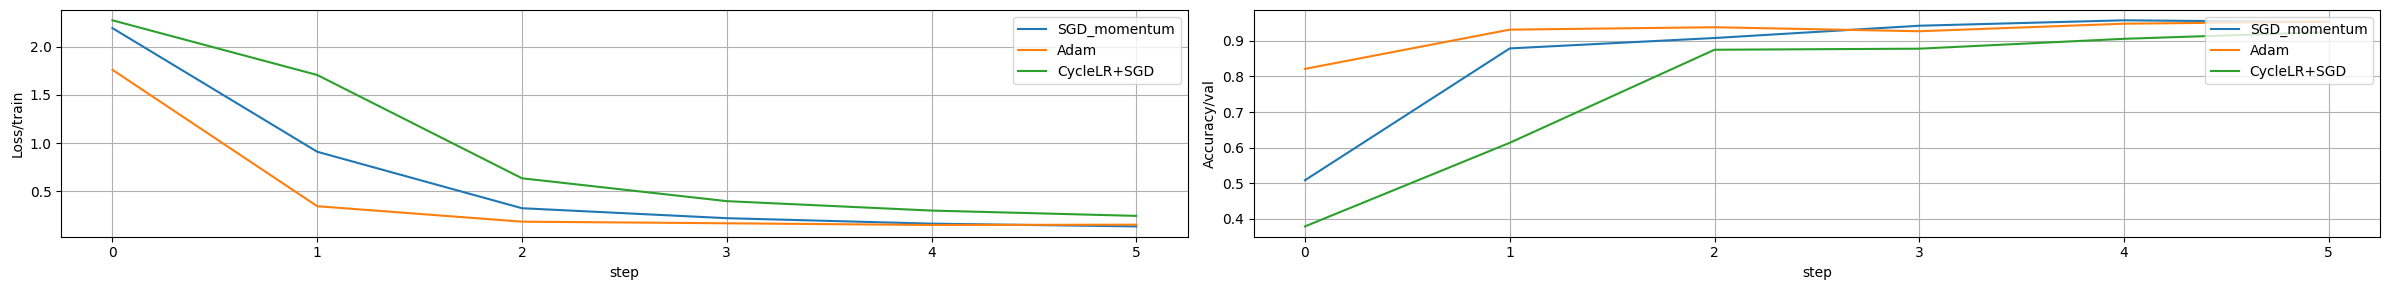

In [17]:
pp.set_title("CycleLR+SGD")
model = LeNet()
trainer = LRSchedulerTrainer(model, pp, min_lr, max_lr)
trainer.optimizer = torch.optim.SGD(trainer.model.parameters(), lr=0.03)
trainer(train_loader, val_loader)

Посчитайте итоговое значение accuracy на val_data с помощью функции validate.  

In [18]:
test_val = validate(trainer.model.eval(), val_loader, device)
print(f'Test accuracy: {test_val:.4f}')

Test accuracy: 0.9247


**Напишите Вывод**:


Точность везде примерно ожинаковая, но в последнем случае модель обучается медленнее

## Формат результата

* Графики loss-функции, пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_3_ex07_v1.png" width="1200" >


* вывод

# Задание 2. Dropout

Добавьте в вашу нейросеть Dropout на последних слоях.

Обучите ее на наборе данных MNIST. После этого, сделайте предсказание на тестовом датасете НЕ ДЕЛАЯ model.eval. Повторите процедуру предсказания 20 раз.
Выведите 10 изображений, в классификации которых нейросеть больше всего не уверена (на 20 запусков предсказывала им самые различные классы) и 10 изображений, в классификации которых нейросеть больше всего уверена.



In [19]:
import torch
import torch.nn as nn

class LeNet_D(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) # 28*28 -> padding=2 -> 32*32 -> kernel 5*5 -> 28*28, 6 feature maps
        self.pool = nn.MaxPool2d(2)                # 28*28 -> 14*14, 6 feature maps
        self.conv2 = nn.Conv2d(6, 16, 5)           # 14*14 -> kernel 5*5, no padding -> 10*10, 16 feature maps
        self.pool = nn.MaxPool2d(2)                # 10*10 -> 5*5, 16 feature maps
        self.fc1 = nn.Linear(16 * 5 * 5, 120)      # 120 neurons
        self.fc2 = nn.Linear(120, 84)              # 84 neurons
        self.fc3 = nn.Linear(84, 10)               # 10 outputs
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
      x = self.activation(self.pool(self.conv1(x)))
      x = self.activation(self.pool(self.conv2(x)))
      x = self.activation(self.fc1(x.flatten(start_dim=1)))
      x = self.activation(self.fc2(self.dropout(x)))
      x = self.fc3(x)
      return x

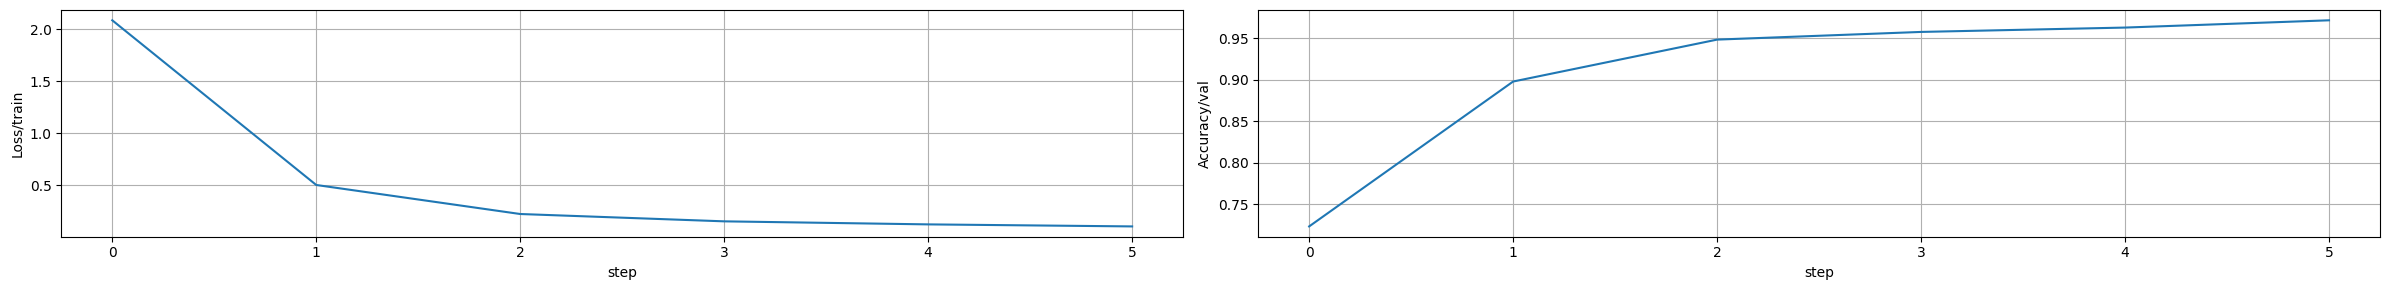

In [20]:
pp = ProgressPlotter("Dropout")
model = LeNet_D()
trainer = Trainer(model, plotter=pp)
trainer.optimizer = torch.optim.SGD(trainer.model.parameters(), momentum=0.5, lr=0.05)
trainer(train_loader, val_loader)

In [21]:
test_val = validate(trainer.model.eval(), val_loader, device)
print(f'Test accuracy: {test_val:.4f}')

Test accuracy: 0.9738


In [22]:
ans = []
for i in range(20):
  preds = []
  for imgs, labels in (test_loader):
    pred = model(imgs.to(device))
    for j in pred.cpu().detach().numpy():
      preds.append(j)
  ans.append(preds)

In [23]:
ans = np.array(ans)
print(ans.shape)
ans = ans.swapaxes(0,1)
print(ans.shape)

(20, 9984, 10)
(9984, 20, 10)


In [24]:
max_conf = np.max(ans, axis=2)
mean_conf = np.mean(max_conf, axis=1)
min_ind = np.argsort(mean_conf)[:10]
max_ind = np.argsort(mean_conf)[-10:]

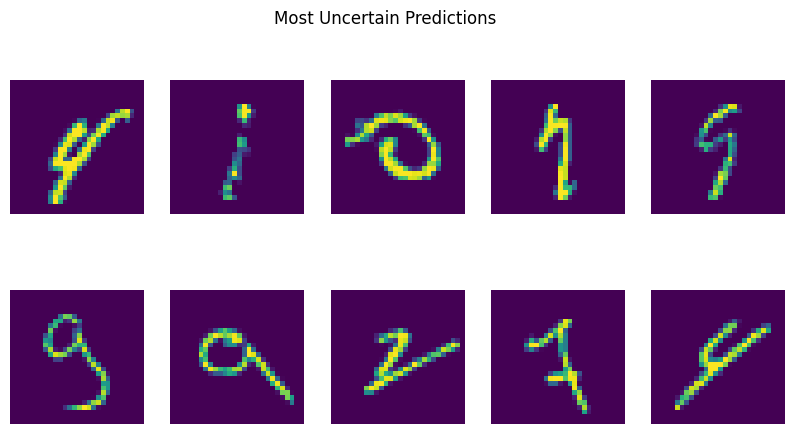

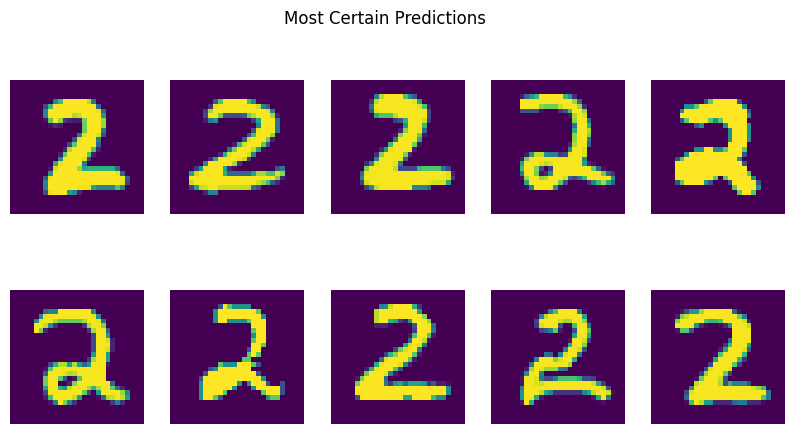

In [25]:
def plot_images(indices, title):
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(mnist_test.data[index].numpy())
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(min_ind, 'Most Uncertain Predictions')
plot_images(max_ind, 'Most Certain Predictions')

## Формат результата

* Изображения

Изображения в которых модель уверена больше всего:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_4_ex07_v1.png" width="1200" >


Изображения в которых модель не уверена больше всего:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_2_task_4_ex07_v1.png" width="1200" >

*Необязательно у вас должны получиться эти же самые картинки.

# Задание 3. Глубокая сеть

Опишите сверточную архитектуру для классификации CIFAR10. Доведите в ней число общее число слоев минимум до 9. Используйте правильную инициализацию весов, [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d) между слоями и другие техники улучшения сходимости обсуждавшиеся в лекции.

* Обучитете модель на датасете CIFAR10.
* **Отладку рекомендуем проводить на фрагменте датасета**.
* Оцените точность классификации на **тестовых данных**.
* Сравните точность с результатами полученными на прошлом занятии.




Загрузим CIFAR10

In [26]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                [0.4914, 0.4822, 0.4465],
                                                [0.2470, 0.2434, 0.2615])])

cifar = CIFAR10(root='CIFAR10', train=True, download=True, transform=transform)
cifat_test = CIFAR10(root='CIFAR10', train=False, download=True, transform=transform)

train_set_cifar, val_set_cifar, = torch.utils.data.random_split(cifar, [45000, 5000])

batch_size = 256

train_loader_cifar = DataLoader(train_set_cifar, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_cifar = DataLoader(val_set_cifar, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_cifar = DataLoader(cifat_test, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:19<00:00, 8576615.42it/s] 


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


In [27]:
class CifarNN(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        in_channels = 3
        size = 32

        for i in range(6):
            layers.append(nn.Conv2d(in_channels, 2*in_channels, kernel_size=3, padding=1))
            in_channels = 2*in_channels
            layers.append(nn.BatchNorm2d(in_channels))
            layers.append(nn.ReLU())

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        size //= 2
        layers.append(nn.Dropout(p=0.1))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_channels * size * size, 128))
        layers.append(nn.BatchNorm1d(128))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(128, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

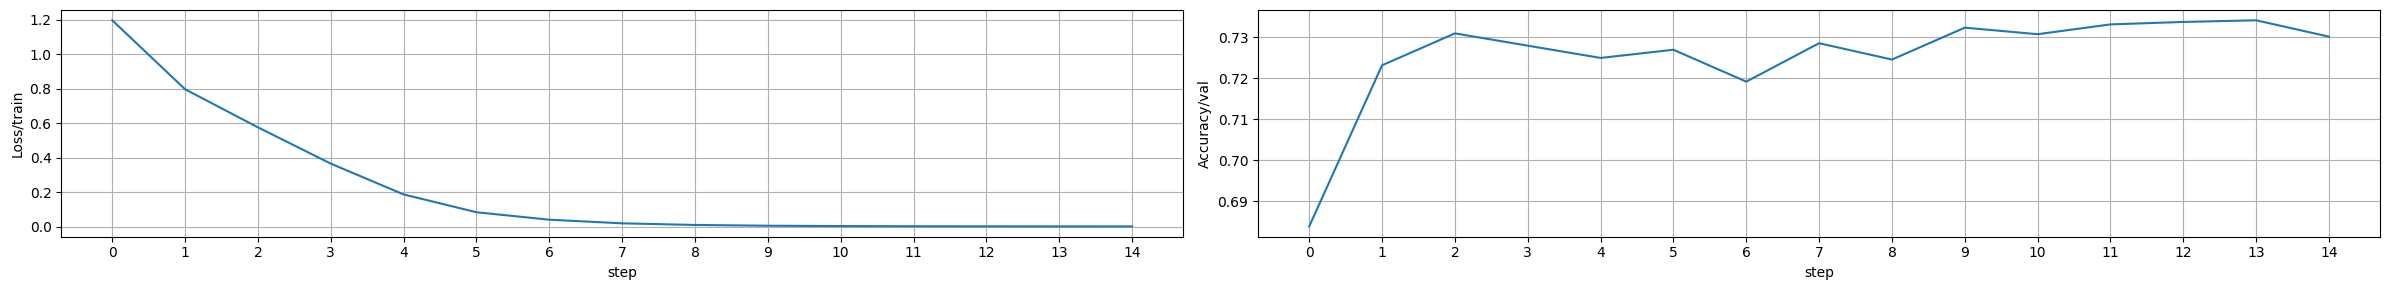

In [28]:
pp = ProgressPlotter(title='Cifar')
model = CifarNN()
trainer = Trainer(model, plotter=pp)
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.001)
trainer(train_loader_cifar, val_loader_cifar, epochs=15)

In [29]:
test_acc = validate(trainer.model.eval(), test_loader_cifar, device)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.7386


На треировочных loss падает, accuracy начал выходить на плато - больше обучать не надо, так как начнется переобучение

## Формат результата

* Графики loss и accuracy при обучении


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_5_ex07_v1.png" width="1200" >

* Знaчение accuracy на тесте должно составить не менее 0.7


